In [1]:
import scipy.linalg._interpolative as _id
import numpy as np
import scipy
import scipy.linalg.interpolative as sli
from time import perf_counter

import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange
from scipy.io import mmread
from PIL import Image
import glob

In [2]:
rng = np.random.default_rng()

In [3]:
# def _asfortranarray_copy(A):
#     A = np.asarray(A)
#     if A.flags.f_contiguous:
#         A = A.copy(order="F")
#     else:
#         A = np.asfortranarray(A)
#     return A

In [4]:
# def iddr_id(A, k):
#     A = _asfortranarray_copy(A)
#     idx, rnorms = _id.iddr_id(A, k)
#     n = A.shape[1]
#     proj = A.T.ravel()[:k*(n-k)].reshape((k, n-k), order='F')
#     return idx-1, proj

In [5]:
def optim_id(A, k):
    """Computes a rank-k ID approximation using an optimized least-squares solver."""
    
    # if A is (m,n) with m <= n, then Q is (m,m), R is (m,n), and P is (n,)
    _, R, P = scipy.linalg.qr(A, pivoting=True, mode='economic', check_finite=False)

    R_k = R[:k,:k]
    cols = P[:k]
    
    C = A[:,cols]
    
    try:
        Z = scipy.linalg.solve(R_k.T @ R_k, C.T @ A, overwrite_a=True, overwrite_b=True, assume_a='pos')
    except np.linalg.LinAlgError:
        data_rank = np.linalg.matrix_rank(A)
        raise ValueError(f"Invalid input: rank of data ({data_rank}) is less than requested rank of approximation ({k}).")

    approx = C @ Z

    return approx, cols, Z

In [6]:
def optim_tri_id(A, k):
    """Computes a rank-k ID approximation using an optimized least-squares solver."""
    
    _, n = A.shape
    
    # if A is (m,n) with m <= n, then Q is (m,m), R is (m,n), and P is (n,)
    _, R, P = scipy.linalg.qr(A, pivoting=True, check_finite=False)
    
    
    # invert permutation
    s = np.empty_like(P)
    s[P] = np.arange(P.size)
    

    R_k = R[:k,:k]
    cols = P[:k]
    
    C = A[:,cols]
    
    try:
        Z = scipy.linalg.solve_triangular(R_k, R[:k,s], overwrite_b=True, check_finite=False)
    except np.linalg.LinAlgError:
        data_rank = np.linalg.matrix_rank(A)
        raise ValueError(f"Invalid input: rank of data ({data_rank}) is less than requested rank of approximation ({k}).")
    
    approx = C @ Z

    return approx, cols, Z

In [7]:
# def scipy_iddr_id(A, k):
#     idx, proj = iddr_id(A,k)
#     cols = idx[:k]
#     C = A[:,cols]
#     Z = sli.reconstruct_interp_matrix(idx, proj)
#     approx = np.dot(C, Z)
#     return approx, cols, Z

In [8]:
def scipy_id_main(A, k, randomized):
    idx, proj = sli.interp_decomp(A, k, rand=randomized)
    cols = idx[:k]
    C = A[:,cols]
    Z = sli.reconstruct_interp_matrix(idx, proj)
    approx = np.dot(C, Z)
    return approx, cols, Z

def scipy_id(A, k):
    return scipy_id_main(A, k, randomized=False)

def scipy_rid(A, k):
    return scipy_id_main(A, k, randomized=True)

In [9]:
def _optim_rid(A, k, oversampling=10):
    """Computes a randomized rank-k ID approximation using an optimized least-squares solver."""
    
    if oversampling < 0:
        raise ValueError('Oversampling parameter cannot be negative.')
        
    p = k + oversampling
    if p > A.shape[1]:
        raise ValueError('Oversampling parameter is too large.')
    
    idx = rng.choice(A.shape[1], replace=False, size=p)
    AS = A[:,idx]
    
    # if AS is (m,p) with m >= p, then Q is (m,p), R is (p,p), and P is (p,)
    Q, R, P = scipy.linalg.qr(AS, pivoting=True, mode='economic', check_finite=False)

    Q_k = Q[:,:k]  # removes the p-k oversampled columns
    R_k = R[:k,:k]
    _cols = P[:k]
    cols = idx[_cols]
    
    C = AS[:,_cols]
    # because rank(AS) may be < k, we use 'sym' instead of 'pos'
    Z = scipy.linalg.solve(R_k.T @ R_k, C.T @ A, overwrite_a=True, overwrite_b=True, assume_a='sym')
    approx = C @ Z
    
    return approx, cols, Z

In [10]:
def optim_rid(A, k):
    o = int(0.2 * k)
    return _optim_rid(A, k, oversampling=o)

In [11]:
def svd(A, k):
    """Computes the optimal deterministic rank-k approximation of the SVD of the input matrix."""
    U, sigma, Vh = np.linalg.svd(A, full_matrices=False)
    Sigma = np.diag(sigma[:k])
    return U[:,:k] @ Sigma @ Vh[:k], None, None

In [12]:
def calculate_error(data, A):
    return np.linalg.norm(data - A) / np.linalg.norm(data)

In [13]:
n_domain = np.arange(1000, 5000, step=1000)
n_len = n_domain.shape[0]

In [14]:
def create_gaussian(n):
     return rng.standard_normal(size=(n,n))

In [15]:
DET_ID_ALGS = [scipy_id, scipy_rid, optim_tri_id, optim_id, optim_rid]
DET_ALGS = [svd] + DET_ID_ALGS
num_det_algs = len(DET_ALGS)

DET_ERRORS = np.empty((num_det_algs, n_len))
DET_TIMES = np.empty((num_det_algs, n_len))
DET_MAX_ENTRY = np.empty((num_det_algs-1, n_len))


for i, n in enumerate(tqdm(n_domain)):
    for h, alg in enumerate(tqdm(DET_ALGS, leave=False)):
        data = create_gaussian(n)
        start = perf_counter()
#         k = int(0.2 * n)
        k = 400
        approx, cols, Z = alg(data, k)
        end = perf_counter()
        
        DET_TIMES[h,i] = end - start
        DET_ERRORS[h,i] = calculate_error(data, approx)
        
        if alg == svd:
            continue
        
        # check_columns(data[:,cols], approx[:,cols], alg.__name__)  # uncomment to verify correctness of algorithms
        DET_MAX_ENTRY[h-1,i] = np.max(np.abs(Z))

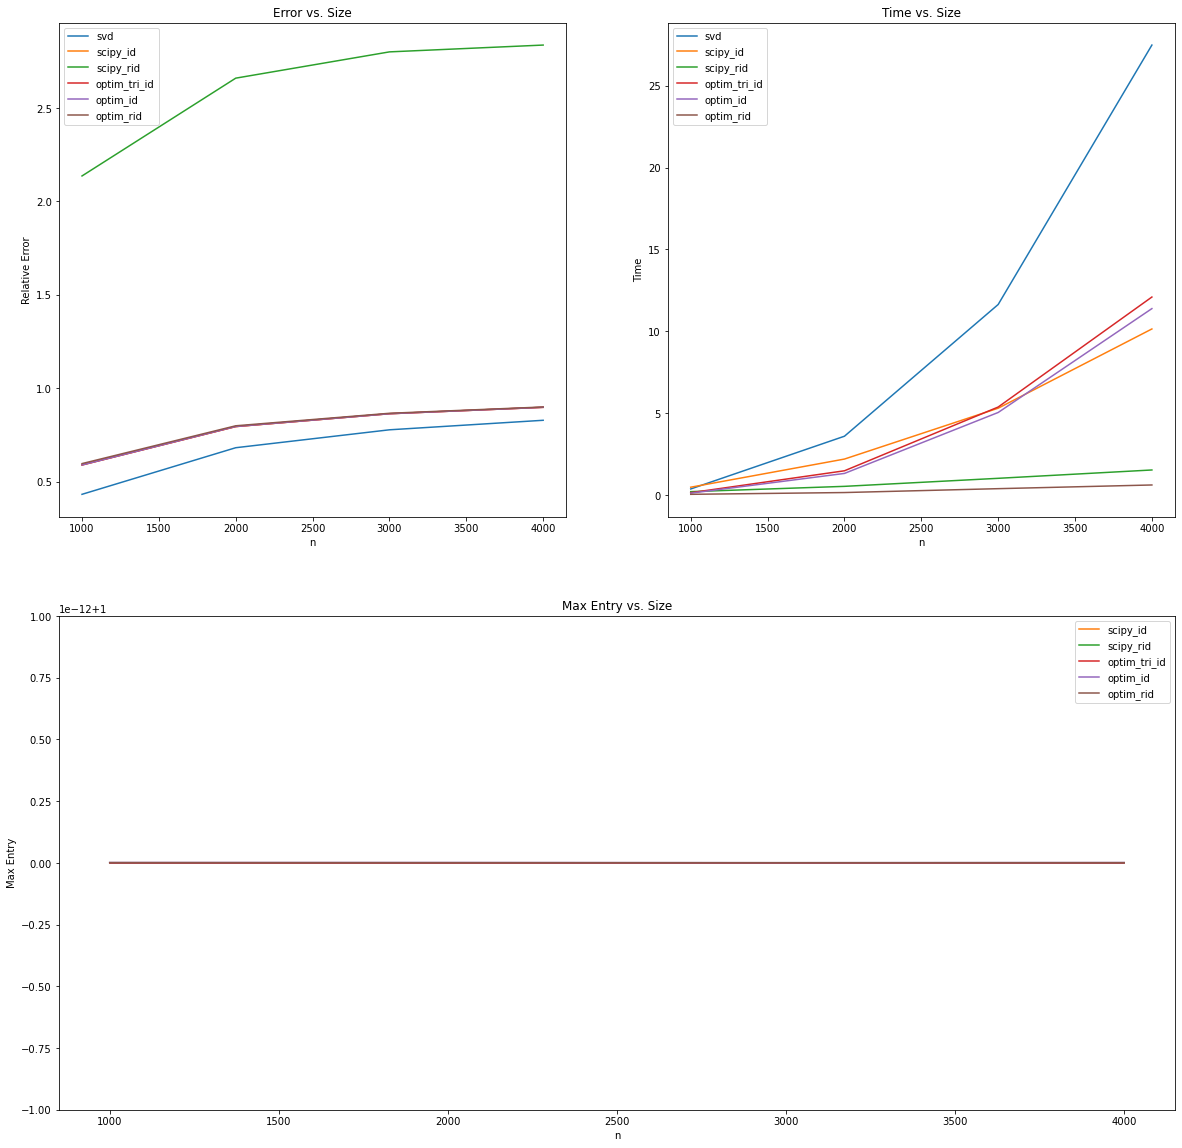

In [16]:
fig = plt.figure(figsize=(20,20))
fig.set_facecolor('#FFF')  # '#EEE' for grey
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
axs = [ax1, ax2, ax3]



# ERROR GRAPH
idx = 0
for h, alg in enumerate(DET_ALGS):
    alg_name = alg.__name__
    axs[idx].plot(n_domain, DET_ERRORS[h], label=alg_name)

axs[idx].set_xlabel('n')
axs[idx].set_ylabel('Relative Error')
axs[idx].legend(loc='best')
axs[idx].set_title('Error vs. Size')


# TIME GRAPH
idx = 1
for h, alg in enumerate(DET_ALGS):
    alg_name = alg.__name__
    axs[idx].plot(n_domain, DET_TIMES[h], label=alg_name)

axs[idx].set_xlabel('n')
axs[idx].set_ylabel('Time')
# axs[idx].set_yscale('log')
axs[idx].legend(loc='best')
axs[idx].set_title('Time vs. Size')


# MAX ENTRY GRAPH
idx = 2
axs[idx].plot([], [])  # null plot to advance color cycler to stay in sync with previous plots
for h, alg in enumerate(DET_ID_ALGS):
    alg_name = alg.__name__
    axs[idx].plot(n_domain, DET_MAX_ENTRY[h], label=alg_name)

axs[idx].set_xlabel('n')
axs[idx].set_ylabel('Max Entry')
# axs[idx].set_yscale('log')
axs[idx].legend(loc='best')
axs[idx].set_title('Max Entry vs. Size');